170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


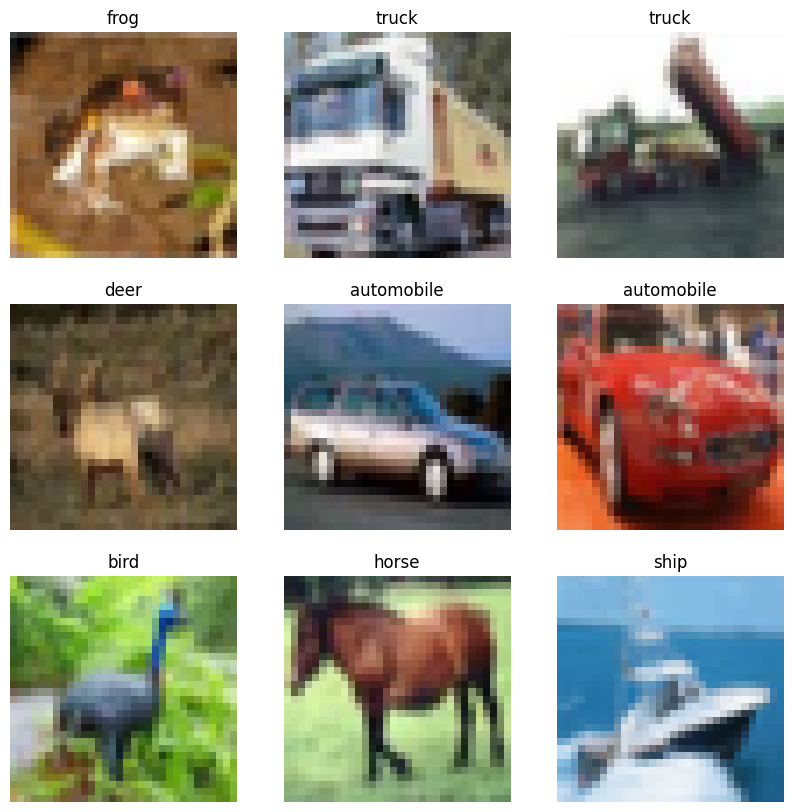

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 30, 30, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 13, 13, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 4, 4, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │        65,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 122,570 (478.79 KB)

 Trainable params: 122,570 (478.79 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 72s 45ms/step - accuracy: 0.3612 - loss: 1.7198 - val_accuracy: 0.5414 - val_loss: 1.2689
Epoch 2/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 80s 44ms/step - accuracy: 0.5844 - loss: 1.1684 - val_accuracy: 0.6458 - val_loss: 1.0072
Epoch 3/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 81s 43ms/step - accuracy: 0.6488 - loss: 0.9871 - val_accuracy: 0.6512 - val_loss: 0.9711
Epoch 4/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 83s 44ms/step - accuracy: 0.6950 - loss: 0.8743 - val_accuracy: 0.6609 - val_loss: 0.9670
Epoch 5/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 83s 45ms/step - accuracy: 0.7224 - loss: 0.8049 - val_accuracy: 0.6905 - val_loss: 0.8871
Epoch 6/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 70s 44ms/step - accuracy: 0.7399 - loss: 0.7446 - val_accuracy: 0.6986 - val_loss: 0.8720
Epoch 7/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 70s 44ms/step - accuracy: 0.7624 - loss: 0.6753 - val_accuracy: 0.6919 - val_loss: 0.9115
Epoch 8/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 69s 44ms/step - accuracy: 0.7742 -

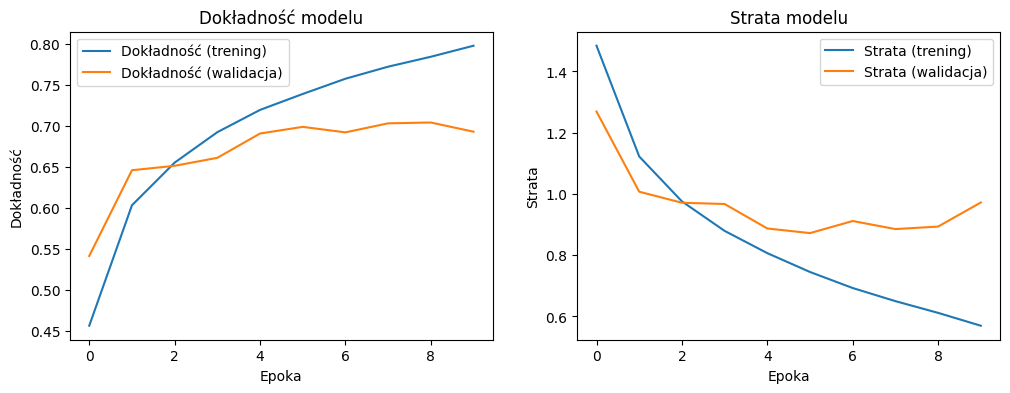

313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step


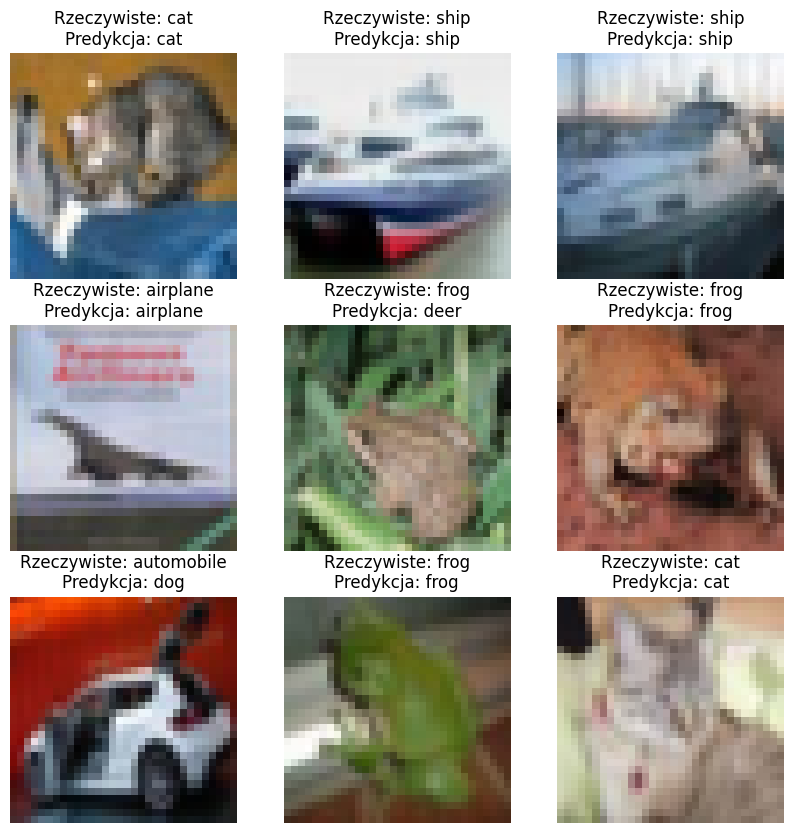

<Figure size 1000x1000 with 0 Axes>

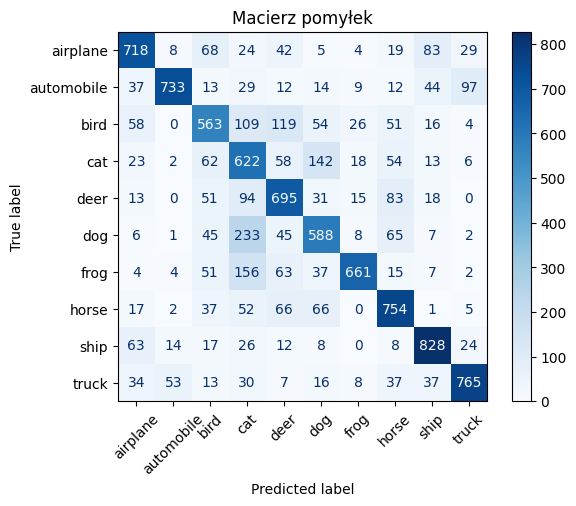


Prześlij obraz do klasyfikacji:


Saving Bez tytułu.png to Bez tytułu.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


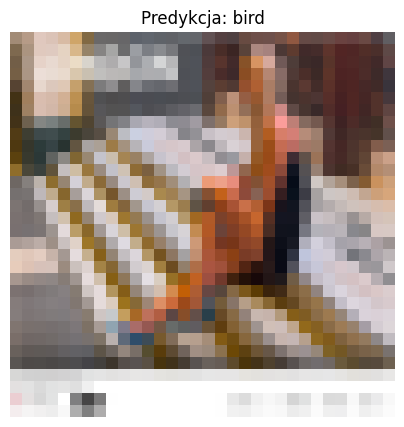

<ipython-input-2-f5ef5280e85d>:109: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = tf.keras.applications.MobileNetV2(input_shape=(32, 32, 3), include_top=False, weights='imagenet')


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/5
1365/1563 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - accuracy: 0.2667 - loss: 2.0263

KeyboardInterrupt: 

In [ ]:
# Instalacja bibliotek
!pip install tensorflow matplotlib numpy

# Importowanie bibliotek
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from google.colab import files
import cv2
from PIL import Image
import io

# Wczytanie CIFAR-10
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']
train_images = train_images / 255.0
test_images = test_images / 255.0

# Wyświetlenie przykładów
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(train_images[i])
    plt.title(class_names[train_labels[i][0]])
    plt.axis('off')
plt.show()

# Budowa modelu CNN
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(10, activation='softmax')
])
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

# Trenowanie modelu
history = model.fit(train_images, train_labels, epochs=10,
                    validation_data=(test_images, test_labels))
test_loss, test_acc = model.evaluate(test_images, test_labels)
print(f"\nDokładność na zbiorze testowym: {test_acc:.4f}")

# Wykresy dokładności i straty
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Dokładność (trening)')
plt.plot(history.history['val_accuracy'], label='Dokładność (walidacja)')
plt.title('Dokładność modelu')
plt.xlabel('Epoka')
plt.ylabel('Dokładność')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Strata (trening)')
plt.plot(history.history['val_loss'], label='Strata (walidacja)')
plt.title('Strata modelu')
plt.xlabel('Epoka')
plt.ylabel('Strata')
plt.legend()
plt.show()

# Predykcje i macierz pomyłek
predictions = model.predict(test_images)
predicted_labels = np.argmax(predictions, axis=1)
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(test_images[i])
    plt.title(f"Rzeczywiste: {class_names[test_labels[i][0]]}\nPredykcja: {class_names[predicted_labels[i]]}")
    plt.axis('off')
plt.show()
cm = confusion_matrix(test_labels, predicted_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
plt.figure(figsize=(10, 10))
disp.plot(cmap='Blues')
plt.title('Macierz pomyłek')
plt.xticks(rotation=45)
plt.show()

# Klasyfikacja własnego obrazu
def classify_uploaded_image(model, class_names):
    uploaded = files.upload()
    for fn in uploaded.keys():
        img = Image.open(io.BytesIO(uploaded[fn]))
        img = img.resize((32, 32))
        img_array = np.array(img) / 255.0
        img_array = np.expand_dims(img_array, axis=0)
        prediction = model.predict(img_array)
        predicted_class = class_names[np.argmax(prediction)]
        plt.figure(figsize=(5, 5))
        plt.imshow(img_array[0])
        plt.title(f"Predykcja: {predicted_class}")
        plt.axis('off')
        plt.show()

print("\nPrześlij obraz do klasyfikacji:")
classify_uploaded_image(model, class_names)

# Transfer learning z MobileNetV2
base_model = tf.keras.applications.MobileNetV2(input_shape=(32, 32, 3), include_top=False, weights='imagenet')
base_model.trainable = False
model_transfer = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dense(10, activation='softmax')  # Poprawiona linia
])
model_transfer.compile(optimizer='adam',
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])
history_transfer = model_transfer.fit(train_images, train_labels, epochs=5,
                                     validation_data=(test_images, test_labels))
test_loss_transfer, test_acc_transfer = model_transfer.evaluate(test_images, test_labels)
print(f"\nDokładność modelu transfer learning: {test_acc_transfer:.4f}")